## Setup

In [1]:
import pandas as pd
import numpy as np

import scipy.sparse

from sklearn.metrics import (confusion_matrix, precision_recall_curve, 
                            precision_score, recall_score, accuracy_score,
                            roc_curve, roc_auc_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate


%matplotlib inline
from matplotlib import pyplot as plt

import jellyfish

In [2]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    plt.ylim([0, 1])

In [3]:
def print_thresholds_stats(y_true, y_pred, min_threshold, max_threshold, num=20):
    """Print out accuracy, precision, recall, and confusion counts."""
    print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
    for cutoff in np.linspace(min_threshold, max_threshold, num=num):
        y_train_pred = (y_pred > cutoff)
        print('{:.3f}'.format(cutoff), end='\t')
        print('{:.3f}'.format(accuracy_score(y_true, y_train_pred)), end='\t')
        print('{:.3f}'.format(precision_score(y_true, y_train_pred)), end='\t')
        print('{:.3f}'.format(recall_score(y_true, y_train_pred)), end='\t')
        tn, fp, fn, tp = confusion_matrix(y_true, y_train_pred).ravel()
        print(sum(y_train_pred), end='\t\t')
        print(fp, end='\t')
        print(fn, end='\t')
        print(tp, end='\t')
        print(tn)

In [4]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Training Dataset

### Load training data

In [5]:
df_full = pd.read_csv('../data/real_data/copd_train.csv', sep='^', header=None, names=['Text', 'COPD'])

# Lowercase data
df_full['Text2'] = df_full.Text.str.lower()

# Drop duplicates
df__no_dupes = df_full.drop_duplicates().copy().reset_index()

### TFIDF

In [6]:
# Create TF-IDF object that split data into sublists from a single word to four words (4-gram)
tfidf = TfidfVectorizer(ngram_range=(1,4))

mat_0 = tfidf.fit_transform(df__no_dupes.Text2)

voc_reverse = {v:k for k,v in tfidf.vocabulary_.items()}

### Distance features

Engineer features that capture the edit distance from the four proxy terms.

In [7]:
df__no_dupes['jaro_copd'] = df__no_dupes.Text2.map(lambda s: jellyfish.jaro_winkler('copd', s))

df__no_dupes['jaro_copd_full'] = df__no_dupes.Text2.map(lambda s: jellyfish.jaro_winkler('chronic obstructive pulmonary disease', s))

df__no_dupes['dl_copd'] = df__no_dupes.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('copd', s) / max(len('copd'), len(s))))

df__no_dupes['dl_copd_full'] = df__no_dupes.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('chronic obstructive pulmonary disease', s) / max(len('chronic obstructive pulmonary disease'), len(s))))

Combine the new distance features with the TF-IDF matrix created earlier.

In [8]:
distance_cols = ['jaro_copd', 'jaro_copd_full', 'dl_copd', 'dl_copd_full']

mat = scipy.sparse.hstack([mat_0, df__no_dupes[distance_cols].values])

### Random Forest Classifier

#### Look at cross validated metrics

In [9]:
rfc = RandomForestClassifier()

r = cross_validate(rfc, 
               X=mat, 
               y=df__no_dupes.COPD, 
               scoring=['accuracy', 'precision', 'recall'], 
               return_train_score=True)
r

{'fit_time': array([5.43331695, 4.6319139 , 5.09511709]),
 'score_time': array([0.29795623, 0.24538994, 0.27148223]),
 'test_accuracy': array([0.99718574, 0.99324451, 0.99624695]),
 'test_precision': array([0.98089172, 0.97101449, 0.97402597]),
 'test_recall': array([0.92771084, 0.80722892, 0.90361446]),
 'train_accuracy': array([0.99981235, 0.9994371 , 0.99981237]),
 'train_precision': array([1., 1., 1.]),
 'train_recall': array([0.9939759 , 0.98192771, 0.9939759 ])}

In [10]:
pd.DataFrame(r)[['test_accuracy', 'test_precision', 'test_recall']].mean()

test_accuracy     0.995559
test_precision    0.975311
test_recall       0.879518
dtype: float64

#### Get cross validated predctions  and predicted probabilites

Note: Random Forests do not have decision functions

In [12]:
labels = cross_val_predict(rfc, mat, df__no_dupes.COPD)
proba = cross_val_predict(rfc, mat, df__no_dupes.COPD, method='predict_proba')

In [37]:
df__no_dupes['rfc'] = labels
df__no_dupes['predict_proba__1'] = proba[:,1]

In [38]:
y_true = df__no_dupes.COPD
y_pred_classes = labels

print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
print('{:.3f}'.format(.5), end='\t')
print('{:.3f}'.format(accuracy_score(y_true, y_pred_classes)), end='\t')
print('{:.3f}'.format(precision_score(y_true, y_pred_classes)), end='\t')
print('{:.3f}'.format(recall_score(y_true, y_pred_classes)), end='\t')
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()
print(sum(y_pred_classes), end='\t\t')
print(fp, end='\t')
print(fn, end='\t')
print(tp, end='\t')
print(tn)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.500	0.996	0.984	0.876	443		7	62	436	15483


#### Precision Recall chart

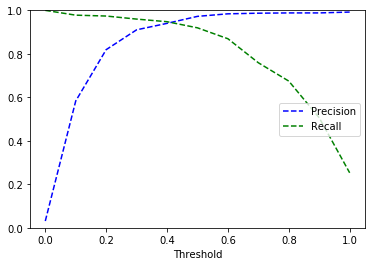

In [15]:
precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, 
                                                         probas_pred=df__no_dupes.predict_proba__1) # decision_function or predict_probas

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

View metrics for various threshold values

In [19]:
print_thresholds_stats(df__no_dupes.COPD, df__no_dupes['predict_proba__1'], 0, 1)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.000	0.978	0.583	0.978	835		348	11	487	15142
0.053	0.978	0.583	0.978	835		348	11	487	15142
0.105	0.992	0.819	0.974	592		107	13	485	15383
0.158	0.992	0.819	0.974	592		107	13	485	15383
0.211	0.996	0.910	0.960	525		47	20	478	15443
0.263	0.996	0.910	0.960	525		47	20	478	15443
0.316	0.996	0.940	0.948	502		30	26	472	15460
0.368	0.996	0.940	0.948	502		30	26	472	15460
0.421	0.997	0.972	0.920	471		13	40	458	15477
0.474	0.997	0.972	0.920	471		13	40	458	15477
0.526	0.995	0.984	0.869	440		7	65	433	15483
0.579	0.995	0.984	0.869	440		7	65	433	15483
0.632	0.992	0.987	0.759	383		5	120	378	15485
0.684	0.992	0.987	0.759	383		5	120	378	15485
0.737	0.990	0.988	0.675	340		4	162	336	15486
0.789	0.990	0.988	0.675	340		4	162	336	15486
0.842	0.984	0.988	0.506	255		3	246	252	15487
0.895	0.984	0.988	0.506	255		3	246	252	15487
0.947	0.977	0.992	0.253	127		1	372	126	15489
1.000	0.969	0.000	0.000	0		0	498	0	15490


/Users/mpitlyk/miniconda3/envs/DS3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
SELECTED_THRESHOLD = .26

In [39]:
y_true = df__no_dupes.COPD
y_pred_classes = (df__no_dupes.predict_proba__1 > SELECTED_THRESHOLD).astype(int)

print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
print('{:.3f}'.format(.5), end='\t')
print('{:.3f}'.format(accuracy_score(y_true, y_pred_classes)), end='\t')
print('{:.3f}'.format(precision_score(y_true, y_pred_classes)), end='\t')
print('{:.3f}'.format(recall_score(y_true, y_pred_classes)), end='\t')
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()
print(sum(y_pred_classes), end='\t\t')
print(fp, end='\t')
print(fn, end='\t')
print(tp, end='\t')
print(tn)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.500	0.996	0.910	0.960	525		47	20	478	15443


#### ROC curve

In [22]:
fpr, tpr, thresholds = roc_curve(y_true=df__no_dupes.COPD, y_score=df__no_dupes.predict_proba__1)

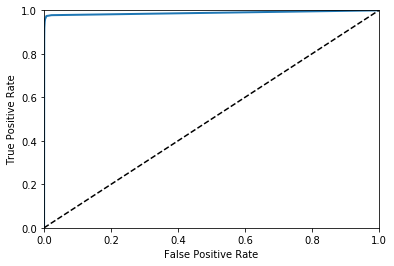

In [23]:
plot_roc_curve(fpr, tpr)
plt.show()

In [25]:
roc_auc_score(y_true=df__no_dupes.COPD, y_score=df__no_dupes.predict_proba__1)

0.9883312462244069

#### Train final model on all training data

This is the trained classifier that will be used on the test dataset.

In [26]:
rfc = RandomForestClassifier()

In [28]:
rfc.fit(X=mat, y=df__no_dupes.COPD)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Test Dataset

In [29]:
df_full_test = pd.read_csv('../data/real_data/copd_test.csv', sep='^', header=None, names=['Text', 'COPD'])

# Lowercase data
df_full_test['Text2'] = df_full_test.Text.str.lower()

# Drop duplicates
df__no_dupes_test = df_full_test.drop_duplicates().copy().reset_index()

### TFIDF

In [30]:
# Use the same TF-IDF object on the test data that was trained on the training data
mat_test_0 = tfidf.transform(df__no_dupes_test.Text2)

### Distance features

Engineer features that capture the edit distance from the four proxy terms.

In [31]:
df__no_dupes_test['jaro_copd'] = df__no_dupes_test.Text2.map(lambda s: jellyfish.jaro_winkler('copd', s))

df__no_dupes_test['jaro_copd_full'] = df__no_dupes_test.Text2.map(lambda s: jellyfish.jaro_winkler('chronic obstructive pulmonary disease', s))

df__no_dupes_test['dl_copd'] = df__no_dupes_test.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('copd', s) / max(len('copd'), len(s))))

df__no_dupes_test['dl_copd_full'] = df__no_dupes_test.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('chronic obstructive pulmonary disease', s) / max(len('chronic obstructive pulmonary disease'), len(s))))

Combine the new distance features with the TF-IDF matrix created earlier.

In [32]:
mat_test = scipy.sparse.hstack([mat_test_0, df__no_dupes_test[distance_cols].values])

### Predict on Test data

In [33]:
y_test_pred = rfc.predict_proba(mat_test)

In [34]:
y_test_pred_classes = (y_test_pred[:,1] > SELECTED_THRESHOLD).astype(int)

In [35]:
y_test_true = df__no_dupes_test.COPD

In [36]:
print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
print('{:.3f}'.format(SELECTED_THRESHOLD), end='\t')
print('{:.3f}'.format(accuracy_score(y_test_true, y_test_pred_classes)), end='\t')
print('{:.3f}'.format(precision_score(y_test_true, y_test_pred_classes)), end='\t')
print('{:.3f}'.format(recall_score(y_test_true, y_test_pred_classes)), end='\t')
tn, fp, fn, tp = confusion_matrix(y_test_true, y_test_pred_classes).ravel()
print(sum(y_test_pred_classes), end='\t\t')
print(fp, end='\t')
print(fn, end='\t')
print(tp, end='\t')
print(tn)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.260	0.998	0.937	0.995	207		13	1	194	5935
